# Detección de fugas de un depósito

> Técnicas Avanzadas de Análisis de Datos

> Daute Rodríguez Rodríguez

## Objetivo

El objetivo de la práctica consiste en construir un sistema capaz de detectar fugas en un depósito. Para ello se contará con registros diarios con la siguiente información:

* Volumen de líquido medido al comienzo del día.
* Volumen de líquido descargado a lo largo del día.
* Volumen de líquido extraído a lo largo del día.
* Volumen de líquido medido al final del día.

Cada una de estos datos está sujeto a errores de medición.

## Preparación

Importación de las librerías y utilidades necesarias para la ejecución del código del Notebook.

In [0]:
import numpy as np
import pandas as pd
from filterpy.kalman import KalmanFilter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Establecimiento de algunas opciones de formato.

In [0]:
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set()

Establecimiento de la semilla para la reproductibilidad de los experimentos aleatorios.

In [0]:
seed = 23
np.random.seed(seed)

## Variables del problema

En esta sección se establecen los valores de las variables del problema:

* _noiseDistributionStdDev_: Desviación típica de la distribución normal con la que se obtendrá el ruido de medida
* _daysWithoutLeakage_: Cantidad de días en los que se asegura que no habrán fugas
* _extraDays_: Cantidad de días en los que es posible que se produzca una fuga
* _days_: Cantidad total de días
* _initialVolume_: Cantidad inicial de litros en el depósito
* _minVolume_ y _maxVolume_: Cantidad mínima y máxima de volumen para las extracciones y las descargas de líquido
* _minLeakPerHour_ y _maxLeakPerHour_: Caudal mínimo y máximo por hora de las posibles fugas que se produzcan
* _leakageProbability_: Probabilidad de que ocurra una fuga por secuencia generada
* _movingAverageWindowSize_: Tamaño de la ventana para la media móvil que se aplica sobre la diferencia del valor predicho por el filtro de Kalman y el valor medido

In [0]:
noiseDistributionStdDev = 3
daysWithoutLeakage = 28
extraDays = 28
days = daysWithoutLeakage + extraDays
initialVolume = 1000
minVolume = 10
maxVolume = 15
minLeakPerHour = 0.1
maxLeakPerHour = 0.9
leakageProbability = 0.3
movingAverageWindowSize = 14

## Funciones auxiliares

Definición de algunas funciones auxiliares:

In [0]:
def round(value, precision=3):
    '''Redondea un valor con precision 3 por defecto'''
    return np.round(value, precision)

def GetMeasurementNoise():
    '''Devuelve una cantidad de ruido aleatoria (distribución normal)'''
    return round(np.random.normal(0, noiseDistributionStdDev))

def GetRandomVolume():
    '''Devuelve una cantidad de volumen aleatoria'''
    return round(np.random.uniform(minVolume, maxVolume))

def GetMovingAverage(df, variable, windowSize):
    '''Devuelve la media móvil de una variable'''
    return pd.Series(df[variable]).rolling(window=windowSize)\
            .mean()\
            .iloc[windowSize - 1:]\
            .values

## Clase _Sequence_

Clase que representa una secuencia de mediciones tal y como quedan descritas en el enunciado del problema. Cuando se inicializa un objeto de esta clase se determinan los siguientes aspectos:

* Presencia de fuga de líquido
* Si la hubiera, día de inicio de la fuga
* En caso de que hubiera fuga, volumen de líquido perdido por hora

Además, se genera de forma aleatoria un historial de mediciones con extracciones y descargas con ruido (a partir de los parámetros especificados anteriormente). Al mismo tiempo, se utiliza un filtro de Kalman que se va actualizando con las medidas realizadas.

A continuación se enumeran las particularidades del filtro de Kalman diseñado para el problema:

1. El estado queda definido por una única variable (matriz 1x1), el volumen de líquido en el depósito al final del día.
2. El valor inicial del estado se establece al valor de volumen inicial con ruido de medida.
3. Las descargas y extracciones de líquido se han contemplado como _control vector_ (matriz 1x2).
4. El _control-input model (B)_ queda definido como la matriz de dimensiones 2x1 siguiente: [[1], [-1]]. Al multiplicarlo por el _control vector_ se obtiene la cantidad de líquido que se ha de añadir (o quitar) del estado.
5. El modelo de transición de estados es una matriz de dimensión 1x1: [[1]], al igual que el _observation model_.
6. Para la covarianza del ruido de proceso se ha decidido mantener el valor por defecto, es decir, una matriz identidad de tamaño 1.
7. Para la covarianza del ruido de medida se ha establecido la desviación típica de las medidas del sensor. (variable _noiseDistributionStdDev_)

In [0]:
class Sequence:
    
    seqId = None
    df = None
    leakage = None
    leakageStart = None
    leakPerHour = None
    leakPerDay = None
    kf = None
    
    def __init__(self, seqId):
        self.seqId = seqId
        self.leakage = np.random.uniform() <= leakageProbability
        self.leakageStart = int(round(np.random.uniform(daysWithoutLeakage, daysWithoutLeakage + extraDays), 0))
        self.leakPerHour = round(np.random.uniform(minLeakPerHour, maxLeakPerHour))
        self.leakPerDay = self.leakPerHour * 24
        
        self.kf = KalmanFilter(dim_x=1, dim_z=1, dim_u=2)
        self.kf.B = np.array([[1, -1]])
        self.kf.F = np.array([[1]])
        self.kf.H = np.array([[1]])
        self.kf.P = np.array([[1]])
        self.kf.R = np.array([[noiseDistributionStdDev]])
        self.kf.Q = np.array([[1]])
        
        self.df = pd.DataFrame(self.GenerateData(), columns=[
            'day', 'initial', 'discharged', 
            'actualDischarged', 'extracted', 
            'actualExtracted', 'final', 
            'actual', 'leak', 'predicted', 'diff'
        ])
    
    def GenerateData(self):
        values = [{
            'day': 0, 'initial': initialVolume,  'discharged': 0,  
            'actualDischarged': 0, 'extracted': 0, 'actualExtracted': 0, 
            'final': initialVolume,  'actual': initialVolume, 'leak': 0,
            'predicted': 0, 'diff': 0
        }]
        noisyInitialVolume = initialVolume + GetMeasurementNoise()
        initial = initialVolume
        
        self.kf.x = np.array([noisyInitialVolume])
        
        for day in range(days):
            extracted = GetRandomVolume() 
            extractionsNoise = GetMeasurementNoise()
            discharged = GetRandomVolume()
            dischargesNoise = GetMeasurementNoise()
            measurementNoise = GetMeasurementNoise()
            leak = self.leakPerDay if self.leakage and day >= self.leakageStart else 0.0

            actual = round(initialVolume + discharged - extracted - leak)
            measurement = round(noisyInitialVolume + (discharged + dischargesNoise) - (extracted + extractionsNoise) - leak + measurementNoise)
            
            self.kf.predict(np.array([[discharged + dischargesNoise], [extracted + extractionsNoise]]))
            self.kf.update(np.array([measurement]))

            values.append({
                'day': day + 1, 'initial': noisyInitialVolume, 
                'discharged': (discharged + dischargesNoise), 'actualDischarged': discharged, 
                'extracted': (extracted - extractionsNoise), 'actualExtracted': extracted,
                'final': measurement, 'actual': actual, 'leak': leak, 'predicted': self.kf.x[0][0],
                'diff': measurement - self.kf.x[0][0]
            })
            initial = actual
            noisyInitialVolume = measurement
        
        return values

La siguiente función se encarga de construir numerosas secuencias y preparar las estructuras de datos necesarias:

* _sequencesDataDf_: DataFrame con información de cada secuencia generada
    * _id_: ID de la secuencia
    * _leakage: Booleano indicando si en la secuencia se produce fuga
    * _leakageStart_: Día de inicio de la fuga (en caso de que la hubiera)
    * _leakPerHour_: Caudal de la fuga (en caso de que la hubiera)
    * _initialVolume_: Volumen inicial del depósito
* _sequences_: Array de objetos _Sequence_

Cabe destacar que se generan secuencias con y sin fuga atendiendo a la variable _leakageProbability_ establecida con anterioridad. También se selecciona de manera aleatoria la gravedad de la fuga (l/h perdidos) y el día de inicio (respetando la cantidad de días sin fuga).

In [0]:
def ConstructSequences(amount):
    sequences = []
    sequencesData = []
    
    for id in range(amount):
        seq = Sequence(id)
        sequences.append(seq)
        sequencesData.append({
            'id': id,
            'leakage': seq.leakage,
            'leakageStart': seq.leakageStart,
            'leakPerHour': seq.leakPerHour,
            'initialVolume': initialVolume
        })
    
    sequencesDataDf = pd.DataFrame(sequencesData, columns=['id', 'leakage', 'leakageStart', 'leakPerHour', 'initialVolume'])
    return sequencesDataDf, sequences

En la siguiente celda de código se generan 500 secuencias. Se utilizaran para entrenar un modelo que permita detectar si se producen fugas en un depósito.

In [0]:
sequencesDataDf, sequences = ConstructSequences(500)

## Detección de fugas

Para la detección de fugas se utilizará la evolución de la diferencia existente entre las mediciones realizadas y las predicciones obtenidas por el filtro de Kalman. A continuación se muestran dos ejemplos de esta variable, uno en el caso de secuencia con fuga y otro en el caso de secuencia sin fuga:

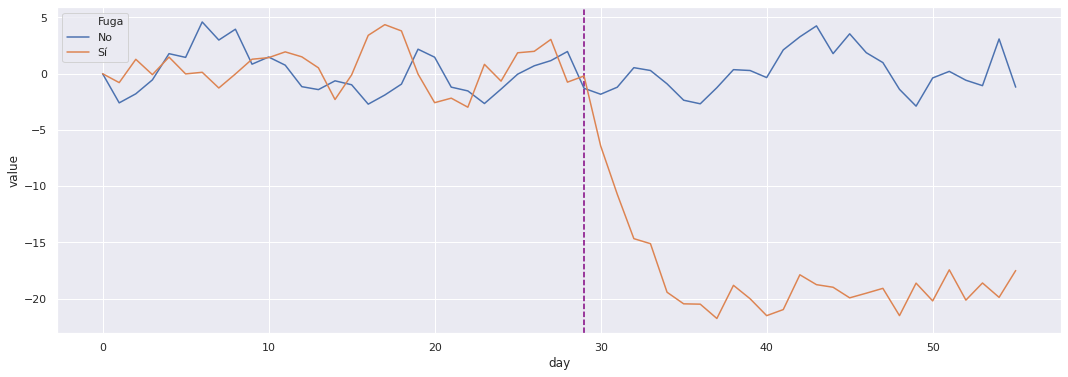

In [0]:
chartData = []
for day in range(days):
    chartData.append({'day': day, 'value': sequences[0].df['diff'].iloc[day], 'Fuga': 'No'})
    chartData.append({'day': day, 'value': sequences[498].df['diff'].iloc[day], 'Fuga': 'Sí'})

plt.figure(figsize=(18,6))
plt.axvline(sequencesDataDf.iloc[498]['leakageStart'], color='purple', ls='--')
sns.lineplot(x='day', y='value', hue='Fuga', data=pd.DataFrame(chartData, columns=['day', 'value', 'Fuga']));

Tal y como puede apreciarse, para el caso de secuencia con fuga se produce un brusco descenso en los valores de la variable a partir del día en el que se produjo la fuga aproximadamente. Este fenómeno puede explicarse atendiendo al funcionamiento del filtro de Kalman. El filtro de Kalman es capaz de mitigar las impresiciones que se producen al realizar mediciones que quedan afectadas por un ruido Gaussiano. Tras una fuga, todos los días se pierde una cantidad de líquido. Esta pérdida no puede verse reflejada en las predicciones que realiza el filtro puesto que se trata de un suceso desconocido. Dado que ambas señales presentan características fácilmente distinguibles, se ha optado por construir un modelo de clasificación capaz de detectar si se producen fugas a partir de señales de este estilo, con una ligera modificación previa.

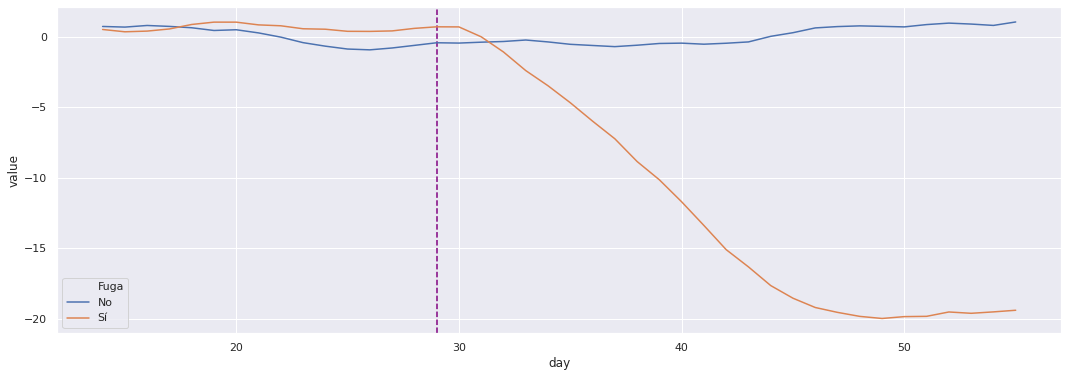

In [0]:
chartData = []
notLeakage = GetMovingAverage(sequences[0].df, 'diff', movingAverageWindowSize)
leakage = GetMovingAverage(sequences[498].df, 'diff', movingAverageWindowSize)
for day in range(days - movingAverageWindowSize):
    chartData.append({'day': day + movingAverageWindowSize, 'value': notLeakage[day], 'Fuga': 'No'})
    chartData.append({'day': day + movingAverageWindowSize, 'value': leakage[day], 'Fuga': 'Sí'})

plt.figure(figsize=(18,6))
plt.axvline(sequencesDataDf.iloc[498]['leakageStart'], color='purple', ls='--')
sns.lineplot(x='day', y='value', hue='Fuga', data=pd.DataFrame(chartData, columns=['day', 'value', 'Fuga']));

En esta figura se muestran las señales obtenidas tras aplicar la ligera modificación mencionada a las señales de la figura anterior. Tal y como puede apreciarse se ha conseguido facilitar más la identificación de los dos tipos de señal. Dicha modificación no es más que un simple filtro de la media móvil. Con un valor adecuado para el parámetro de la ventana de la media móvil, se consigue eliminar el ruido preservando la "tendencia" de las señales (su forma).

En las siguientes celdas de código se realizan las acciones necesarias para dividir el conjunto de 500 secuencias generadas en subconjuntos de entrenamiento y testeo, teniendo en cuenta el balance de clases para no introducir patrones indeseados que el modelo a entrenar pueda aprender. Los tamaños de cada subconjunto son 70% y 30% respectivamente.

In [0]:
def PrepareSequences(index, sequencesArray):
    values = []
    for i in index:
        df = sequencesArray[i].df
        values.append(GetMovingAverage(df, 'diff', movingAverageWindowSize))
    
    return pd.DataFrame(values, index=index)

In [0]:
X = sequencesDataDf['id']
y = sequencesDataDf['leakage']

stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

stratSplit.get_n_splits(X, y)

for train_index, test_index in stratSplit.split(X, y):
    X_train_index, X_test_index = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = PrepareSequences(X_train_index, sequences)
X_test = PrepareSequences(X_test_index, sequences)

Como modelo de clasificación se ha optado por utilizar regresión logística dando como entrada los distintos valores de la señal obtenida al aplicar el filtro de la media móvil sobre la señal a clasificar. El número total de variables queda definido por la ecuación:

> nº variables = nº total de días - tamaño de la ventana

Dado que la evaluación de observaciones es un proceso poco costoso en la regresión logística (suma de multiplicaciones del valor de cada variable por su respectivo peso y comprobación de si el resultado supera un cierto umbral), la gran cantidad de variables no suponen un problema a tener en cuenta si el valor total de días no es excesivamente grande. A continuación se entrena el modelo y se muestran tanto la precisión y la matriz de confusión obtenida al clasificar las observaciones del conjunto de testeo.

Precision: 0.9666666666666667


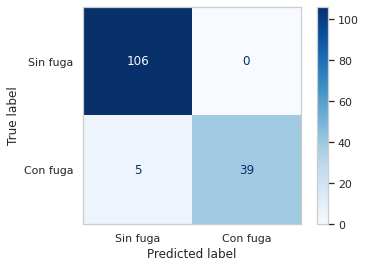

In [0]:
clf = LogisticRegression(max_iter=2000).fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Precision:', clf.score(X_test, y_test))
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Sin fuga', 'Con fuga'], cmap=plt.cm.Blues, values_format = '');

Tal y como puede apreciarse, tanto la precisión obtenida como la matriz de confusión muestran que el comportamiento del modelo es bastante bueno. Atendiendo a los falsos negativos (fugas no detectadas), podemos apreciar que se producen en dos situaciones:

* La gravedad de la fuga es alta pero se produce prácticamente en el último día del periodo de observación
* La gravedad de la fuga es baja pero se produce cerca de la fecha de finalización

En ambos casos, al modelo le cuesta distinguir las señales mostradas previamente. La diferencia entre señales con fuga y señales sin fuga no es tan obvia, y por ello el clasificador no es capaz de discriminar estas observaciones.

In [0]:
falseNegatives = ((y_test == True) & (y_pred == False))
sequencesDataDf.loc[y_test[falseNegatives].index]

,id,leakage,leakageStart,leakPerHour,initialVolume
356,356,True,55,0.647,1000
88,88,True,49,0.121,1000
133,133,True,55,0.789,1000
119,119,True,50,0.143,1000
44,44,True,55,0.752,1000


En las siguientes celdas de código se vuelven a generar otras 500 secuencias que serán clasificadas por el modelo entrenado previamente. Como en el caso anterior, los resultados son buenos.

In [0]:
sequencesDataDf, sequences = ConstructSequences(500)

y = sequencesDataDf['leakage']
X = PrepareSequences(sequencesDataDf.index, sequences)

Precision: 0.96


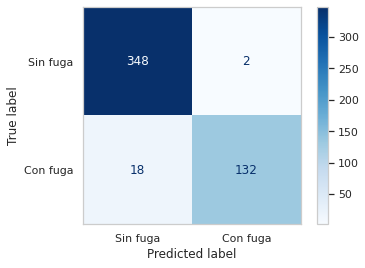

In [0]:
y_pred = clf.predict(X)
print('Precision:', clf.score(X, y))
sns.set_style("whitegrid", {'axes.grid' : False})
plot_confusion_matrix(clf, X, y, display_labels=['Sin fuga', 'Con fuga'], cmap=plt.cm.Blues, values_format = '');

La siguiente tabla muestra que la mayoría de falsos negativos en este caso siguen ajustándose a los problemas descritos tras la clasificación del conjunto de testeo. Llama la atención la instancia con identificador 392. Parece que la fuga se produjo lo más rápido posible (un día después del periodo seguro) pero el modelo no fue capaz de detectarla. También hay que destacar que se trata de una fuga de mínima gravedad entre las estudiadas (0.143 l/h). Este falso negativo puede explicarse atendiendo al error de medida del sensor del depósito. El error de medida (3) es practicamente igual a la totalidad de litros que se pierden al día a causa de la fuga (24 x 0.143 = 3.432). Conociendo esto es posible concluir que la fuga ha pasado desapercibida debido a su poco caudal.

In [0]:
falseNegatives = ((y == True) & (y_pred == False))
sequencesDataDf.loc[y[falseNegatives].index]

,id,leakage,leakageStart,leakPerHour,initialVolume
0,0,True,53,0.307,1000
23,23,True,56,0.492,1000
47,47,True,56,0.900,1000
56,56,True,45,0.137,1000
71,71,True,46,0.141,1000
90,90,True,53,0.172,1000
96,96,True,51,0.119,1000
104,104,True,54,0.231,1000
110,110,True,52,0.248,1000
176,176,True,55,0.357,1000


## Conclusiones

A pesar de la simpleza del filtro de Kalman propuesto, se ha podido demostrar cómo su utilización ha hecho posible abordar el problema obteniendo buenos resultados. Del estudio de las fugas no detectadas se han podido detectar los puntos débiles del modelo propuesto:

* **Fugas tardías**: El clasificador parece tener dificultades a la hora de detectar fugas que se producen próximas a la finalización del periodo del que se disponen observaciones. Sin embargo, esto no parece suponer un problema grave pues si se siguen añadiendo medidas el clasificador terminará detectando la fuga, pues la diferencias entre el valor medido y el valor predicho por el filtro de Kalman seguirán aumentando. Claro está que se ha de tener en cuenta el tamaño del periodo de observaciones pues el modelo se ha entrenado para clasificar señales de cierta longitud. A pesar de esto, si se emplean las medidas como una ventana no debería haber problema, es decir, cuando se registra una nueva medida se añadirá a la señal por la cola y se eliminará la medida más antigua registrada. De esta manera, eventualmente se detectará la posible fuga.

* **Fugas leves**: Cuando el caudal de la fuga es lo suficientemente pequeño, las fugas no se detectan independientemente del día de inicio. La causa de esto es la precisión del sensor de medida, si el ruido es mayor que la posible fuga que se produzca resultará extremadamente difícil detectarla. Como posible solución (y línea futura) se podría contemplar el añadir otro sensor de medida de manera que se mitiguen los efectos de los ruidos de medida mediante fusión sensorial.

A pesar de estos puntos débiles, se ha conseguido en cierta medida abordar el objetivo propuesto para la práctica.

## Referencias

En este listado se muestran algunons de los recursos de más utilidad utilizados para la realización de la práctica:

* [Kalman Filter - Wikipedia](https://es.wikipedia.org/wiki/Filtro_de_Kalman)
* [kalmanfilter.net](https://www.kalmanfilter.net/default.aspx)
* [Understanding Kalman Filters - MATLAB YouTube playlist](https://www.youtube.com/playlist?list=PLn8PRpmsu08pzi6EMiYnR-076Mh-q3tWr)
* [FilterPy documentation](https://filterpy.readthedocs.io/en/latest/)